# Social Media ML Paper Agent - Multi-Agent LangGraph System

This notebook implements a multi-agent system that creates social media posts about Machine Learning papers and verifies their correctness and platform appropriateness.

## System Architecture

The system consists of three main teams:

1. **Content Creation Team**: Analyzes ML papers and creates social media content
   - Paper Analyzer Agent
   - Content Creator Agent
   - Platform Optimizer Agent

2. **Verification Team**: Verifies correctness and platform appropriateness
   - Technical Reviewer Agent
   - Style Checker Agent
   - Fact Checker Agent

3. **Meta-Supervisor**: Coordinates between teams and manages the overall workflow

![System Architecture](https://i.imgur.com/placeholder.png)


## Dependencies and Setup


In [21]:
import os
import getpass

# Set up API keys
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY:")


In [43]:
import nest_asyncio
nest_asyncio.apply()


## Import Dependencies


In [42]:
import functools
import operator
import uuid
from pathlib import Path
from typing import Any, Callable, List, Optional, TypedDict, Union, Dict, Annotated

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool, tool
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import END, StateGraph, START


## Helper Functions


In [44]:
def agent_node(state, agent, name):
    """Helper function to create agent nodes"""
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason!")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )


In [45]:
# Create working directory for storing content
os.makedirs('./social_media_content', exist_ok=True)

def create_random_subdirectory():
    random_id = str(uuid.uuid4())[:8]
    subdirectory_path = os.path.join('./social_media_content', random_id)
    os.makedirs(subdirectory_path, exist_ok=True)
    return subdirectory_path

WORKING_DIRECTORY = Path(create_random_subdirectory())

# Initialize search tool
tavily_tool = TavilySearchResults(max_results=5)


In [46]:
@tool
def search_ml_paper_info(
    query: Annotated[str, "Search query for ML paper information"]
) -> str:
    """Search for information about machine learning papers, authors, or concepts."""
    return tavily_tool.invoke(query)

@tool
def create_social_media_post(
    platform: Annotated[str, "Social media platform (twitter, linkedin, instagram)"],
    content: Annotated[str, "Main content of the post"],
    hashtags: Annotated[List[str], "List of relevant hashtags"],
    file_name: Annotated[str, "File name to save the post"]
) -> str:
    """Create a social media post optimized for a specific platform."""
    
    platform_configs = {
        "twitter": {"char_limit": 280, "hashtag_limit": 5},
        "linkedin": {"char_limit": 3000, "hashtag_limit": 10},
        "instagram": {"char_limit": 2200, "hashtag_limit": 30}
    }
    
    config = platform_configs.get(platform.lower(), platform_configs["twitter"])
    
    # Format hashtags
    formatted_hashtags = [f"#{tag.replace('#', '')}" for tag in hashtags[:config["hashtag_limit"]]]
    hashtag_string = " ".join(formatted_hashtags)
    
    # Create platform-specific post
    if platform.lower() == "twitter":
        post = f"{content}\n\n{hashtag_string}"
    elif platform.lower() == "linkedin":
        post = f"{content}\n\n{hashtag_string}\n\n#MachineLearning #AI #Research"
    else:  # Instagram
        post = f"{content}\n\n{hashtag_string}"
    
    # Truncate if necessary
    if len(post) > config["char_limit"]:
        post = post[:config["char_limit"]-3] + "..."
    
    # Save to file
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(f"Platform: {platform}\n")
        file.write(f"Character count: {len(post)}\n")
        file.write(f"Hashtag count: {len(formatted_hashtags)}\n")
        file.write("\n--- POST CONTENT ---\n")
        file.write(post)
    
    return f"Social media post created and saved to {file_name}. Character count: {len(post)}"

@tool
def read_content_file(
    file_name: Annotated[str, "Name of the file to read"]
) -> str:
    """Read the content of a saved file."""
    try:
        with (WORKING_DIRECTORY / file_name).open("r") as file:
            return file.read()
    except FileNotFoundError:
        return f"File {file_name} not found."

@tool
def verify_technical_accuracy(
    paper_info: Annotated[str, "Information about the ML paper"],
    social_post: Annotated[str, "Social media post content"]
) -> str:
    """Verify that the social media post accurately represents the technical content of the paper."""
    
    verification_report = f"""
    TECHNICAL ACCURACY VERIFICATION REPORT
    
    Paper Information:
    {paper_info}
    
    Social Media Post:
    {social_post}
    
    Verification Checklist:
    □ Technical claims are accurate
    □ No oversimplification that leads to misinformation
    □ Proper attribution to authors
    □ Results and claims are not exaggerated
    □ Methodology is correctly described
    
    Recommendations:
    - Check for any technical inaccuracies
    - Ensure claims are supported by the paper
    - Verify that complex concepts are simplified appropriately
    """
    
    return verification_report

@tool
def check_platform_style(
    platform: Annotated[str, "Social media platform"],
    post_content: Annotated[str, "Social media post content"]
) -> str:
    """Check if the post follows the style and best practices for the target platform."""
    
    platform_guidelines = {
        "twitter": {
            "tone": "Concise, engaging, conversational",
            "best_practices": ["Use threads for complex topics", "Include relevant hashtags", "Tag authors if possible"],
            "char_limit": 280
        },
        "linkedin": {
            "tone": "Professional, informative, thought-provoking",
            "best_practices": ["Start with a hook", "Use line breaks for readability", "End with a question or call-to-action"],
            "char_limit": 3000
        },
        "instagram": {
            "tone": "Visual, engaging, accessible",
            "best_practices": ["Use emojis appropriately", "Include many relevant hashtags", "Make it visually appealing"],
            "char_limit": 2200
        }
    }
    
    guidelines = platform_guidelines.get(platform.lower(), platform_guidelines["twitter"])
    
    style_report = f"""
    PLATFORM STYLE VERIFICATION REPORT
    
    Platform: {platform}
    Expected Tone: {guidelines['tone']}
    Character Limit: {guidelines['char_limit']}
    
    Post Content:
    {post_content}
    
    Style Checklist:
    □ Appropriate tone for platform
    □ Within character limits
    □ Follows platform best practices
    □ Engaging and accessible language
    □ Proper use of hashtags and mentions
    
    Best Practices for {platform}:
    {chr(10).join(['- ' + practice for practice in guidelines['best_practices']])}
    
    Recommendations:
    - Ensure the tone matches the platform audience
    - Check character count and hashtag usage
    - Verify engagement potential
    """
    
    return style_report

@tool
def save_verification_report(
    report_content: Annotated[str, "Verification report content"],
    file_name: Annotated[str, "File name for the report"]
) -> str:
    """Save a verification report to a file."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(report_content)
    return f"Verification report saved to {file_name}"


## Team States and Complete System


In [47]:
# Team State Definitions
class ContentTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

class VerificationTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

class MetaState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

# Helper function to track files
def content_prelude(state):
    written_files = []
    if WORKING_DIRECTORY.exists():
        try:
            written_files = [f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*") if f.is_file()]
        except:
            pass
    return state

# Initialize LLMs with different models for different purposes
content_llm = ChatOpenAI(model="gpt-4o-mini")  # Fast and cost-effective for content creation
verification_llm = ChatOpenAI(model="gpt-4o")  # More powerful model for critical verification tasks
meta_llm = ChatOpenAI(model="gpt-4o-mini")    # Efficient for coordination


In [48]:
# Create Content Creation Team Agents
paper_analyzer_agent = create_agent(
    content_llm,
    [search_ml_paper_info],
    "You are an expert ML researcher who analyzes papers to extract key insights for social media content."
)
paper_analyzer_node = functools.partial(agent_node, agent=paper_analyzer_agent, name="PaperAnalyzer")

content_creator_agent = create_agent(
    content_llm,
    [create_social_media_post, read_content_file],
    "You are a social media content creator who makes complex ML research accessible and engaging."
)
content_creator_node = functools.partial(agent_node, agent=content_creator_agent, name="ContentCreator")

platform_optimizer_agent = create_agent(
    content_llm,
    [create_social_media_post, read_content_file, check_platform_style],
    "You optimize content for specific social media platforms considering character limits and best practices."
)
platform_optimizer_node = functools.partial(agent_node, agent=platform_optimizer_agent, name="PlatformOptimizer")

# Content Team Supervisor
content_supervisor_agent = create_team_supervisor(
    content_llm,
    "You manage a content creation team. Coordinate: analyze paper → create content → optimize for platform. When ready, respond with FINISH.",
    ["PaperAnalyzer", "ContentCreator", "PlatformOptimizer"],
)


In [49]:
# Create Verification Team Agents
technical_reviewer_agent = create_agent(
    verification_llm,
    [read_content_file, verify_technical_accuracy, search_ml_paper_info, save_verification_report],
    "You verify technical accuracy of ML content, ensuring no misinformation or oversimplification."
)
technical_reviewer_node = functools.partial(agent_node, agent=technical_reviewer_agent, name="TechnicalReviewer")

style_checker_agent = create_agent(
    verification_llm,
    [read_content_file, check_platform_style, save_verification_report],
    "You ensure content fits platform requirements including tone, character limits, and engagement strategies."
)
style_checker_node = functools.partial(agent_node, agent=style_checker_agent, name="StyleChecker")

fact_checker_agent = create_agent(
    verification_llm,
    [read_content_file, search_ml_paper_info, save_verification_report],
    "You fact-check claims in social media content and cross-reference with reliable sources."
)
fact_checker_node = functools.partial(agent_node, agent=fact_checker_agent, name="FactChecker")

# Verification Team Supervisor
verification_supervisor_agent = create_team_supervisor(
    verification_llm,
    "You manage a verification team. Ensure comprehensive verification: technical accuracy → platform style → fact-checking. When complete, respond with FINISH.",
    ["TechnicalReviewer", "StyleChecker", "FactChecker"],
)


In [50]:
# Build Content Creation Graph
content_graph = StateGraph(ContentTeamState)
content_graph.add_node("PaperAnalyzer", paper_analyzer_node)
content_graph.add_node("ContentCreator", content_creator_node)
content_graph.add_node("PlatformOptimizer", platform_optimizer_node)
content_graph.add_node("ContentSupervisor", content_supervisor_agent)

content_graph.add_edge("PaperAnalyzer", "ContentSupervisor")
content_graph.add_edge("ContentCreator", "ContentSupervisor")
content_graph.add_edge("PlatformOptimizer", "ContentSupervisor")

content_graph.add_conditional_edges(
    "ContentSupervisor",
    lambda x: x["next"],
    {
        "PaperAnalyzer": "PaperAnalyzer",
        "ContentCreator": "ContentCreator",
        "PlatformOptimizer": "PlatformOptimizer",
        "FINISH": END,
    },
)

content_graph.set_entry_point("ContentSupervisor")
compiled_content_graph = content_graph.compile()
compiled_content_graph

# Build Verification Graph
verification_graph = StateGraph(VerificationTeamState)
verification_graph.add_node("TechnicalReviewer", technical_reviewer_node)
verification_graph.add_node("StyleChecker", style_checker_node)
verification_graph.add_node("FactChecker", fact_checker_node)
verification_graph.add_node("VerificationSupervisor", verification_supervisor_agent)

verification_graph.add_edge("TechnicalReviewer", "VerificationSupervisor")
verification_graph.add_edge("StyleChecker", "VerificationSupervisor")
verification_graph.add_edge("FactChecker", "VerificationSupervisor")

verification_graph.add_conditional_edges(
    "VerificationSupervisor",
    lambda x: x["next"],
    {
        "TechnicalReviewer": "TechnicalReviewer",
        "StyleChecker": "StyleChecker",
        "FactChecker": "FactChecker",
        "FINISH": END,
    },
)

verification_graph.set_entry_point("VerificationSupervisor")
compiled_verification_graph = verification_graph.compile()


In [52]:
# Helper functions for meta-supervisor
def enter_content_chain(message: str, members: List[str]):
    return {"messages": [HumanMessage(content=message)], "team_members": members}

def enter_verification_chain(message: str, members: List[str]):
    return {"messages": [HumanMessage(content=message)], "team_members": members}

# Create chain interfaces
content_chain = (
    functools.partial(enter_content_chain, members=list(content_graph.nodes))
    | compiled_content_graph
)

verification_chain = (
    functools.partial(enter_verification_chain, members=list(verification_graph.nodes))
    | compiled_verification_graph
)

# Helper functions for meta state management
def get_last_message(state: MetaState) -> str:
    return state["messages"][-1].content

def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

# Meta-supervisor
meta_supervisor_agent = create_team_supervisor(
    meta_llm,
    "You coordinate between content creation and verification teams. First create content, then verify it. When both are complete, respond with FINISH.",
    ["ContentTeam", "VerificationTeam"],
)

# Build Meta-Supervisor Graph
meta_graph = StateGraph(MetaState)
meta_graph.add_node("ContentTeam", get_last_message | content_chain | join_graph)
meta_graph.add_node("VerificationTeam", get_last_message | verification_chain | join_graph)
meta_graph.add_node("MetaSupervisor", meta_supervisor_agent)

meta_graph.add_edge("ContentTeam", "MetaSupervisor")
meta_graph.add_edge("VerificationTeam", "MetaSupervisor")
meta_graph.add_conditional_edges(
    "MetaSupervisor",
    lambda x: x["next"],
    {
        "ContentTeam": "ContentTeam",
        "VerificationTeam": "VerificationTeam",
        "FINISH": END,
    },
)

meta_graph.set_entry_point("MetaSupervisor")
compiled_meta_graph = meta_graph.compile()

print("✅ System successfully compiled!")
print("📊 Graphs created:")
print("   - Content Creation Team")
print("   - Verification Team") 
print("   - Meta-Supervisor")


✅ System successfully compiled!
📊 Graphs created:
   - Content Creation Team
   - Verification Team
   - Meta-Supervisor


## Graph Structure Analysis


In [56]:
# Create a new working directory for this example
WORKING_DIRECTORY = Path(create_random_subdirectory())

# Example: Create a Twitter post about the famous Transformer paper
example_request = """
Create a Twitter post about the paper "Attention Is All You Need" by Vaswani et al. 
This is the foundational Transformer paper that introduced the self-attention mechanism 
and revolutionized natural language processing.

Key points:
- Introduced the Transformer architecture
- Self-attention mechanism eliminates need for RNNs/CNNs
- Parallel processing advantages
- Foundation for BERT, GPT, and modern LLMs
- Achieved state-of-the-art translation results

Target platform: Twitter
Make it engaging and accessible to a broad audience!
"""

print("🚀 Starting social media post creation and verification process...")
print(f"📁 Working directory: {WORKING_DIRECTORY}")
print("="*60)

for step in compiled_meta_graph.stream(
    {"messages": [HumanMessage(content=example_request)]},
    {"recursion_limit": 50}
):
    if "__end__" not in step:
        print(step)
        print("---")


🚀 Starting social media post creation and verification process...
📁 Working directory: social_media_content/f9e9491b
{'MetaSupervisor': {'next': 'ContentTeam'}}
---
{'ContentTeam': {'messages': [HumanMessage(content='The Twitter post about the paper "Attention Is All You Need" has been created and optimized! Here’s the final version:\n\n---\n\n🚀 Dive into the revolution of NLP! 🌟 The paper "Attention Is All You Need" by Vaswani et al. introduced the groundbreaking Transformer architecture and self-attention mechanism. 🧠 No more RNNs/CNNs!\n\n💡 Key highlights:\n- Parallel processing = speed 💨\n- Birthplace of BERT, GPT, and modern LLMs!\n- State-of-the-art translation results achieved!\n\n#NLP #MachineLearning #Transformers #AI #Innovation\n\n---\n\nThis has been saved in the file **transformer_paper_tweet.txt**.', additional_kwargs={}, response_metadata={}, name='PlatformOptimizer')]}}
---
{'MetaSupervisor': {'next': 'VerificationTeam'}}
---
{'VerificationTeam': {'messages': [HumanMess

## Example Usage - Create a Twitter Post about Transformers


In [57]:
# Create a new working directory for this example
WORKING_DIRECTORY = Path(create_random_subdirectory())

# Example: Create a Linkedin post about the famous Transformer paper
example_request = """
Create a LinkedIn post about the paper "Attention Is All You Need" by Vaswani et al. 
This is the foundational Transformer paper that introduced the self-attention mechanism 
and revolutionized natural language processing.

Key points:
- Introduced the Transformer architecture
- Self-attention mechanism eliminates need for RNNs/CNNs
- Parallel processing advantages
- Foundation for BERT, GPT, and modern LLMs
- Achieved state-of-the-art translation results

Target platform: LinkedIn
Make it engaging and accessible to a broad audience!
"""

print("🚀 Starting social media post creation and verification process...")
print(f"📁 Working directory: {WORKING_DIRECTORY}")
print("="*60)

for step in compiled_meta_graph.stream(
    {"messages": [HumanMessage(content=example_request)]},
    {"recursion_limit": 50}
):
    if "__end__" not in step:
        print(step)
        print("---")


🚀 Starting social media post creation and verification process...
📁 Working directory: social_media_content/1b9a5987
{'MetaSupervisor': {'next': 'ContentTeam'}}
---
{'ContentTeam': {'messages': [HumanMessage(content='The LinkedIn post about the paper "Attention Is All You Need" has been successfully created and saved. It effectively highlights the key points of the Transformer architecture in an engaging manner. If you\'d like to review or share it, just let me know!', additional_kwargs={}, response_metadata={}, name='PlatformOptimizer')]}}
---
{'MetaSupervisor': {'next': 'VerificationTeam'}}
---
{'VerificationTeam': {'messages': [HumanMessage(content='It seems that the file containing the LinkedIn post for the paper "Attention Is All You Need" is not available. You might want to check if it\'s saved under a different name or re-save the content correctly. If you can provide the content of the post, I can proceed to verify its technical accuracy.', additional_kwargs={}, response_metada

📊 LANGGRAPH VISUAL DIAGRAMS

🔧 Content Creation Team Graph:

🔍 Verification Team Graph:

🎯 Meta-Supervisor Graph:


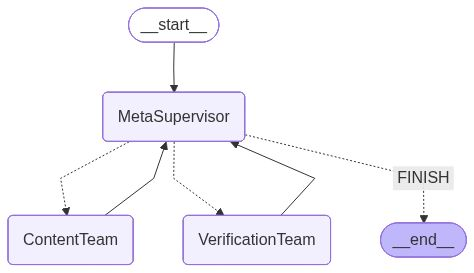

In [59]:
# Display the actual graph objects (same as original notebook)
print("📊 LANGGRAPH VISUAL DIAGRAMS")
print("="*50)

print("\n🔧 Content Creation Team Graph:")
compiled_content_graph

print("\n🔍 Verification Team Graph:")
compiled_verification_graph

print("\n🎯 Meta-Supervisor Graph:")
compiled_meta_graph


## View Generated Content


In [58]:
# Display all files created during the process
print("📄 Files created during the process:")
print("="*40)

if WORKING_DIRECTORY.exists():
    for file_path in WORKING_DIRECTORY.rglob("*"):
        if file_path.is_file():
            print(f"\n📝 {file_path.name}:")
            print("-" * 30)
            with open(file_path, 'r') as f:
                content = f.read()
                print(content)
else:
    print("❌ No files found.")


📄 Files created during the process:

📝 attention_is_all_you_need_linkedin_post.txt:
------------------------------
Platform: linkedin
Character count: 652
Hashtag count: 5

--- POST CONTENT ---
The paper 'Attention Is All You Need' revolutionizes how we approach natural language processing. Introducing the Transformer architecture, it eschews recurrence for self-attention mechanisms, enabling more efficient training and improved performance on various tasks. This innovative model has since become foundational in building state-of-the-art systems across NLP. Check out the full paper for an in-depth understanding of this innovative approach! 🌐 [Read More](https://arxiv.org/abs/1706.03762) What's your take on the impact of Transformers in the AI field?

#MachineLearning #AI #Transformers #DeepLearning #NLP

#MachineLearning #AI #Research

📝 linkedin_attention_style_verification_report.txt:
------------------------------
PLATFORM STYLE VERIFICATION REPORT

Platform: LinkedIn
Expected Tone: